In [ ]:
!pip install transformers datasets peft bitsandbytes accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### LOAD MODEL

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "unsloth/Qwen2.5-7B-Instruct-bnb-4bit"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype="auto")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

### BUILD PROMPT

In [ ]:
def build_prompt(text):
    return f"""Phân loại tin tức.

Tin: "{text}"

Chỉ trả lời duy nhất 1 số:
0 = Tin thật
1 = Tin giả

Chỉ ghi số, không cần giải thích.

Trả lời:"""


### CLASSIFY NEWS

In [ ]:
import torch

def classify(text):
    prompt = build_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=30,
            do_sample=False
        )

    # Giải mã toàn bộ output
    #decoded_full = tokenizer.decode(output[0], skip_special_tokens=True)
    # print("===== FULL OUTPUT (bao gồm prompt + sinh): =====")
    # print(decoded_full)

    decoded_only = tokenizer.decode(output[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True).strip()
    # print("===== CHỈ PHẦN MODEL SINH RA: =====")
    # print(decoded_only)

    # Chỉ lấy token đầu tiên (số 1 or 0), cắt toàn bộ giải thích sau
    first_token = decoded_only[0] if decoded_only and decoded_only[0] in ["0", "1"] else None
    # print(">>> Label trích ra:", first_token)

    # Giải phóng bộ nhớ GPU
    del inputs, output
    torch.cuda.empty_cache()

    return int(first_token)


classify('''
VNINDEX đạt 1500 điểm chỉ sau 3 tháng kể từ sự kiện thiên nga đen
''')


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0

### PREDICT AND SAVE RESULT

In [ ]:
import pandas as pd
from tqdm import tqdm

# Đọc file
df = pd.read_csv('/content/drive/MyDrive/dataset/news/test.csv')

# Phân loại từng bài báo
tqdm.pandas()
df["predict"] = df["post_message"].progress_apply(classify)

# Lưu ra file mới
df.to_csv("prediction.csv", index=False)

100%|██████████| 486/486 [37:49<00:00,  4.67s/it]


In [ ]:
df = pd.read_csv('/content/prediction.csv')
acc = (df['predict'] == df['label']).mean()
print(f'Accuracy: {acc:.4f}')


Accuracy: 0.7325


### VALIDATE THE LLM MODEL

🔹 Đánh giá mô hình:
  - Accuracy : 0.7325
  - Precision: 0.3588
  - Recall   : 0.7439
  - F1-score : 0.4841


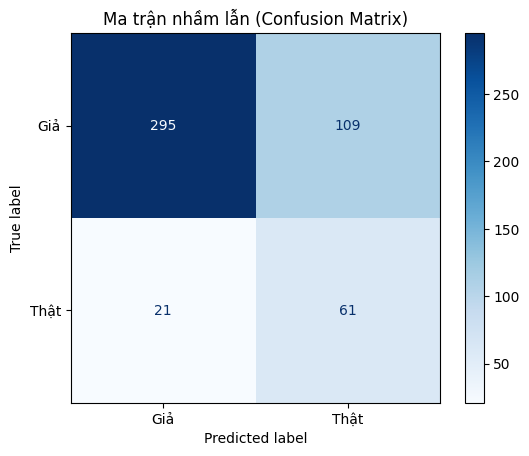

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
df = pd.read_csv("/content/drive/MyDrive/dataset/news/prediction .csv")

# Giả sử label và predict là kiểu số nguyên (0 hoặc 1)
y_true = df['label']
y_pred = df['predict']

# Tính các chỉ số đánh giá
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# In kết quả ra màn hình
print("🔹 Đánh giá mô hình:")
print(f"  - Accuracy : {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall   : {recall:.4f}")
print(f"  - F1-score : {f1:.4f}")

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Giả', 'Thật'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Ma trận nhầm lẫn (Confusion Matrix)")
plt.show()


In [ ]:
df.count()

,0
user_name,486
post_message,486
timestamp_post,486
num_like_post,486
num_comment_post,486
num_share_post,486
label,486
predict,486


🔹 ROC-AUC Score: 0.7371


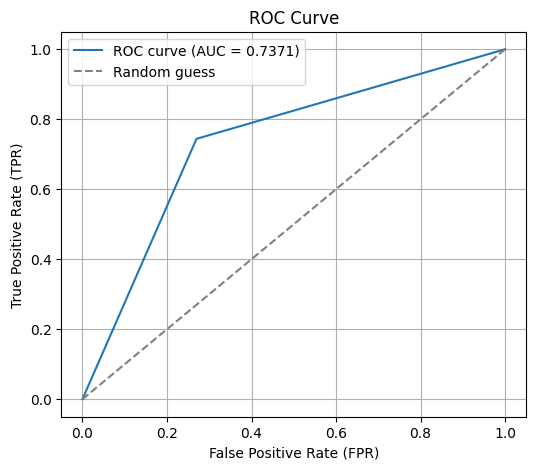

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = df['label']          # nhãn thật
y_score = df['predict']  # xác suất dự đoán (cột này phải có)

# Tính ROC và AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_score = roc_auc_score(y_true, y_score)

print(f"🔹 ROC-AUC Score: {auc_score:.4f}")

# Vẽ đường ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.4f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray', label="Random guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
# print("Trainable params:", trainable_params)
# print("Số trainable params:", len(trainable_params))
